In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow import keras
import warnings
from tqdm import tqdm
from kaggler.preprocessing import LabelEncoder
from kaggler.model import AutoLGB
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile

In [3]:
import kaggler
print(kaggler.__version__)

0.9.3


In [4]:
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
warnings.simplefilter('ignore')

### Load Data

In [5]:
feature_name = 'ae'
algo_name = 'lgb'
model_name = f'{algo_name}_{feature_name}'

feature_file = f'{feature_name}.csv'
predict_val_file = f'{model_name}.val.txt'
predict_tst_file = f'{model_name}.tst.txt'
submission_file = f'{model_name}.sub.csv'

index_col = 'index'
target_col = 'credit'

In [6]:
trn = pd.read_csv('./open/train.csv', index_col=index_col)
print(trn.shape)
trn.head()

(26457, 19)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [7]:
tst = pd.read_csv('./open/test.csv', index_col=index_col)
print(tst.shape)
tst.head()

(10000, 18)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
index,,,,,,,,,,,,,,,,,,
26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [8]:
sub = pd.read_csv('./open/sample_submission.csv', index_col=index_col)
print(sub.shape)
sub.head()

(10000, 3)


,0,1,2
index,,,
26457,0,0,0
26458,0,0,0
26459,0,0,0
26460,0,0,0
26461,0,0,0


### Simple EDA

In [9]:
trn[target_col] = trn[target_col].astype('category')
trn[target_col]

index
0        1.0
1        1.0
2        2.0
3        0.0
4        2.0
        ... 
26452    1.0
26453    2.0
26454    2.0
26455    2.0
26456    2.0
Name: credit, Length: 26457, dtype: category
Categories (3, float64): [0.0, 1.0, 2.0]

In [10]:
for col in trn.columns:
    print(f'{col:>16s}: {trn[col].count()}\t{trn[col].nunique()}\t{trn[col].dtype}')

          gender: 26457	2	object
             car: 26457	2	object
         reality: 26457	2	object
       child_num: 26457	9	int64
    income_total: 26457	249	float64
     income_type: 26457	5	object
        edu_type: 26457	5	object
     family_type: 26457	5	object
      house_type: 26457	6	object
      DAYS_BIRTH: 26457	6621	int64
   DAYS_EMPLOYED: 26457	3470	int64
      FLAG_MOBIL: 26457	1	int64
      work_phone: 26457	2	int64
           phone: 26457	2	int64
           email: 26457	2	int64
      occyp_type: 18286	18	object
     family_size: 26457	10	float64
     begin_month: 26457	61	float64
          credit: 26457	3	category


In [11]:
trn.query('DAYS_EMPLOYED == 365243')  # DAYS_EMPLOYED == 365243인 사람은 전부 pensioner인 점을 알 수 있음

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,1,0,1,0,NaN,1.0,-41.0,2.0
18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,NaN,2.0,-37.0,2.0
21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21253,365243,1,0,1,0,NaN,2.0,-7.0,2.0
24,F,N,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22361,365243,1,0,1,0,NaN,1.0,-5.0,2.0
46,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21100,365243,1,0,1,0,NaN,1.0,-24.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21151,365243,1,0,0,1,NaN,1.0,-60.0,1.0
26432,F,Y,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22314,365243,1,0,1,0,NaN,2.0,-17.0,1.0
26439,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19238,365243,1,0,0,0,NaN,2.0,-57.0,2.0


### Feature Engineering

In [12]:
trn = pd.read_csv('./open/train.csv', index_col=index_col)
tst = pd.read_csv('./open/test.csv', index_col=index_col)

In [13]:
trn.drop('FLAG_MOBIL', axis=1, inplace=True)
tst.drop('FLAG_MOBIL', axis=1, inplace=True)

In [14]:
#trn = trn[-trn.duplicated(trn.columns)]
#tst = tst[-tst.duplicated(tst.columns)]

In [15]:
trn.shape, tst.shape

((26457, 18), (10000, 17))

#### Numerical Features

In [16]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

17 8 9


In [17]:
trn[num_cols] = trn[num_cols] - trn[num_cols].mean()
tst[num_cols] = tst[num_cols] - tst[num_cols].mean()

In [18]:
trn['DAYS_EMPLOYED'] = trn['DAYS_EMPLOYED'].replace(365243, 1)
tst['DAYS_EMPLOYED'] = tst['DAYS_EMPLOYED'].replace(365243, 1)

In [19]:
trn['DAYS_EMPLOYED'] = -trn['DAYS_EMPLOYED']
trn['DAYS_BIRTH'] = -trn['DAYS_BIRTH']
trn['child_ratio'] = trn['child_num'] / trn['family_size']
trn['employed_ratio'] = (-trn['DAYS_EMPLOYED']) / (-trn['DAYS_BIRTH'])
trn['DAYS_EMPLOYED_year'] = (trn['DAYS_EMPLOYED'] / 365).round()
trn['DAYS_BIRTH_year'] = (trn['DAYS_BIRTH'] / 365).round()
trn['begin_month_year'] = ((-trn['begin_month']) / 12).round()
trn['EMPLOYED_begin_month_ratio'] = trn['begin_month'] / (trn['DAYS_EMPLOYED'])
trn['BIRTH_begin_ratio'] = trn['begin_month'] / (trn['DAYS_BIRTH'])
trn['mean_income_family'] = trn['income_total'] / trn['family_size']
trn['income_employed'] = trn['income_total'] * trn['DAYS_EMPLOYED_year']
trn['income_begin_ratio'] = (-trn['begin_month']) / trn['income_total']
trn['family_age_ratio'] = trn['DAYS_BIRTH_year'] / trn['family_size']
trn['family_child_abstract'] = trn['family_size'] - trn['child_num']
trn['begin_month_DAYS_BIRTH'] = trn['begin_month'] * trn['DAYS_BIRTH']
trn['begin_month_DAYS_EMPLOYED'] = trn['begin_month'] * trn['DAYS_EMPLOYED']
trn['income>mean'] = trn['income_total'].apply(lambda x: 1 if x>=trn['income_total'].mean() else 0)
trn['begin_month>mean'] = trn['begin_month'].apply(lambda x: 1 if x>=trn['begin_month'].mean() else 0)
trn['contact'] = trn['phone'] + trn['email'] + trn['work_phone']
trn['begin_month-mean'] = trn['begin_month'] - trn['begin_month'].mean()
trn['income_begin_family_ratio'] = trn['income_begin_ratio'] * trn['family_age_ratio']

# DAYS_BIRTH
trn['DAYS_BIRTH_month'] = np.floor((-trn['DAYS_BIRTH'])/30)-((np.floor((-trn['DAYS_BIRTH'])/30)/12).astype(int)*12)
trn['DAYS_BIRTH_week'] = np.floor((-trn['DAYS_BIRTH'])/7)-((np.floor((-trn['DAYS_BIRTH'])/7)/4).astype(int)*4)
#trn['begin_month_BIRTH_month'] = trn['begin_month'] * trn['DAYS_BIRTH_month']

# DAYS_EMPLOYED
trn['DAYS_EMPLOYED_month'] = np.floor((-trn['DAYS_EMPLOYED'])/30)-((np.floor((-trn['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
trn['DAYS_EMPLOYED_week'] = np.floor((-trn['DAYS_EMPLOYED'])/7)-((np.floor((-trn['DAYS_EMPLOYED'])/7)/4).astype(int)*4)
#trn['begin_month_EMPLOYED_month'] = trn['begin_month'] * trn['DAYS_EMPLOYED_month']

# before_EMPLOYED
trn['before_EMPLOYED'] = trn['DAYS_BIRTH']-trn['DAYS_EMPLOYED']
trn['before_EMPLOYED_month'] = np.floor((-trn['before_EMPLOYED'])/30)-((np.floor((-trn['before_EMPLOYED'])/30)/12).astype(int)*12)
trn['before_EMPLOYED_week'] = np.floor((-trn['before_EMPLOYED'])/7)-((np.floor((-trn['before_EMPLOYED'])/7)/4).astype(int)*4)
trn['before_EMPLOYED_BIRTH_ratio'] = trn['before_EMPLOYED'] / trn['DAYS_BIRTH']
trn['before_EMPLOYED_ratio'] = trn['before_EMPLOYED'] / trn['DAYS_EMPLOYED']
trn['before_EMPLOYED_begin_ratio'] = trn['begin_month'] / trn['before_EMPLOYED']
trn['before_EMPLOYED>mean'] = trn['before_EMPLOYED'].apply(lambda x: 1 if x>=trn['before_EMPLOYED'].mean() else 0)
#trn['begin_month_before_EMPLOYED'] = trn['begin_month'] * trn['before_EMPLOYED']
#trn['begin_month_before_EMPLOYED_month'] = trn['begin_month'] * trn['before_EMPLOYED_month']
#trn['begin_month_before_EMPLOYED_BR'] = trn['begin_month'] * trn['before_EMPLOYED_BIRTH_ratio']
#trn['begin_month_before_EMPLOYED_ratio'] = trn['begin_month'] * trn['before_EMPLOYED_ratio']

In [20]:
tst['DAYS_BIRTH'] = -tst['DAYS_BIRTH']
tst['DAYS_EMPLOYED'] = -tst['DAYS_EMPLOYED']
tst['child_ratio'] = tst['child_num'] / tst['family_size']
tst['employed_ratio'] = (-tst['DAYS_EMPLOYED']) / (-tst['DAYS_BIRTH'])
tst['DAYS_EMPLOYED_year'] = (tst['DAYS_EMPLOYED'] / 365).round()
tst['DAYS_BIRTH_year'] = (tst['DAYS_BIRTH'] / 365).round()
tst['begin_month_year'] = ((-tst['begin_month']) / 12).round()
tst['EMPLOYED_begin_month_ratio'] = tst['begin_month'] / (tst['DAYS_EMPLOYED'])
tst['BIRTH_begin_ratio'] = tst['begin_month'] / (tst['DAYS_BIRTH'])
tst['mean_income_family'] = tst['income_total'] / tst['family_size']
tst['income_employed'] = tst['income_total'] * tst['DAYS_EMPLOYED_year']
tst['income_begin_ratio'] = (-tst['begin_month']) / tst['income_total']
tst['family_age_ratio'] = tst['DAYS_BIRTH_year'] / tst['family_size']
tst['family_child_abstract'] = tst['family_size'] - tst['child_num']
tst['begin_month_DAYS_BIRTH'] = tst['begin_month'] * tst['DAYS_BIRTH']
tst['begin_month_DAYS_EMPLOYED'] = tst['begin_month'] * tst['DAYS_EMPLOYED']
tst['income>mean'] = tst['income_total'].apply(lambda x: 1 if x>=tst['income_total'].mean() else 0)
tst['begin_month>mean'] = tst['begin_month'].apply(lambda x: 1 if x>=tst['begin_month'].mean() else 0)
tst['contact'] = tst['phone'] + tst['email'] + tst['work_phone']
tst['begin_month-mean'] = tst['begin_month'] - tst['begin_month'].mean()
tst['income_begin_family_ratio'] = tst['income_begin_ratio'] * tst['family_age_ratio']

# DAYS_BIRTH
tst['DAYS_BIRTH_month'] = np.floor((-tst['DAYS_BIRTH'])/30)-((np.floor((-tst['DAYS_BIRTH'])/30)/12).astype(int)*12)
tst['DAYS_BIRTH_week'] = np.floor((-tst['DAYS_BIRTH'])/7)-((np.floor((-tst['DAYS_BIRTH'])/7)/4).astype(int)*4)
#tst['begin_month_BIRTH_month'] = tst['begin_month'] * tst['DAYS_BIRTH_month']

# DAYS_EMPLOYED
tst['DAYS_EMPLOYED_month'] = np.floor((-tst['DAYS_EMPLOYED'])/30)-((np.floor((-tst['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
tst['DAYS_EMPLOYED_week'] = np.floor((-tst['DAYS_EMPLOYED'])/7)-((np.floor((-tst['DAYS_EMPLOYED'])/7)/4).astype(int)*4)
#tst['begin_month_EMPLOYED_month'] = tst['begin_month'] * tst['DAYS_EMPLOYED_month']

# before_EMPLOYED
tst['before_EMPLOYED'] = tst['DAYS_BIRTH']-tst['DAYS_EMPLOYED']
tst['before_EMPLOYED_month'] = np.floor((-tst['before_EMPLOYED'])/30)-((np.floor((-tst['before_EMPLOYED'])/30)/12).astype(int)*12)
tst['before_EMPLOYED_week'] = np.floor((-tst['before_EMPLOYED'])/7)-((np.floor((-tst['before_EMPLOYED'])/7)/4).astype(int)*4)
tst['before_EMPLOYED_BIRTH_ratio'] = tst['before_EMPLOYED'] / tst['DAYS_BIRTH']
tst['before_EMPLOYED_ratio'] = tst['before_EMPLOYED'] / tst['DAYS_EMPLOYED']
tst['before_EMPLOYED_begin_ratio'] = tst['begin_month'] / tst['before_EMPLOYED']
tst['before_EMPLOYED>mean'] = tst['before_EMPLOYED'].apply(lambda x: 1 if x>=tst['before_EMPLOYED'].mean() else 0)
#tst['begin_month_before_EMPLOYED'] = tst['begin_month'] * tst['before_EMPLOYED']
#tst['begin_month_before_EMPLOYED_month'] = tst['begin_month'] * tst['before_EMPLOYED_month']
#tst['begin_month_before_EMPLOYED_BR'] = tst['begin_month'] * tst['before_EMPLOYED_BIRTH_ratio']
#tst['begin_month_before_EMPLOYED_ratio'] = tst['begin_month'] * tst['before_EMPLOYED_ratio']

In [21]:
trn['age_group'] = pd.cut(trn['DAYS_BIRTH_year'], bins=[20, 30, 40, 50, 60, 70],
                         labels=['20ager', '30ager', '40ager', '50ager', '60ager']).astype(str)

tst['age_group'] = pd.cut(tst['DAYS_BIRTH_year'], bins=[20, 30, 40, 50, 60, 70],
                         labels=['20ager', '30ager', '40ager', '50ager', '60ager']).astype(str)

In [22]:
trn['begin_month_group'] = pd.cut(trn['begin_month'], bins=[0, 12, 24, 36, 48, 60],
                                  labels=['1year-', '1year+', '2year+', '3year+', '4year+']).astype(str)

tst['begin_month_group'] = pd.cut(tst['begin_month'],  bins=[0, 12, 24, 36, 48, 60],
                                  labels=['1year-', '1year+', '2year+', '3year+', '4year+']).astype(str)

In [23]:
trn = pd.concat([trn, pd.get_dummies(trn['age_group'])], axis=1)
tst = pd.concat([tst, pd.get_dummies(tst['age_group'])], axis=1)

In [24]:
trn['dup']=0
du = list(trn[trn.duplicated(trn.columns)].index)

for i in range(0, 26457):
    if i in du:
        trn.loc[i,'dup']=1

In [25]:
tst['dup']=0
du = list(tst[tst.duplicated(tst.columns)].index)

for i in range(26457, 36457):
    if i in du:
        tst.loc[i,'dup']=1

In [26]:
#trn3 = trn.groupby(['gender', 'income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'])['begin_month'].agg([('begin_month_count', 'count')])
#trn3 = pd.DataFrame(trn3)

#tst3 = tst.groupby(['gender', 'income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'])['begin_month'].agg([('begin_month_count', 'count')])
#tst3 = pd.DataFrame(tst3)

In [27]:
#trn = trn.merge(trn3, how='left', on=('gender', 'income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'))
#tst = tst.merge(tst3, how='left', on=('gender', 'income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'))

In [28]:
#trn['begin_month_mean'] = -trn['begin_month_sum'] / trn['duplicated']
#tst['begin_month_mean'] = -tst['begin_month_sum'] / tst['duplicated']

In [29]:
trn.shape, tst.shape

((26457, 53), (10000, 52))

In [30]:
trn.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,child_ratio,employed_ratio,DAYS_EMPLOYED_year,DAYS_BIRTH_year,begin_month_year,EMPLOYED_begin_month_ratio,BIRTH_begin_ratio,mean_income_family,income_employed,income_begin_ratio,family_age_ratio,family_child_abstract,begin_month_DAYS_BIRTH,begin_month_DAYS_EMPLOYED,income>mean,begin_month>mean,contact,begin_month-mean,income_begin_family_ratio,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week,before_EMPLOYED_BIRTH_ratio,before_EMPLOYED_ratio,before_EMPLOYED_begin_ratio,before_EMPLOYED>mean,age_group,begin_month_group,20ager,nan,dup
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,F,N,N,-0.428658,15193.475507,Commercial associate,Higher education,Married,Municipal apartment,-2059.053899,63777.750728,-0.224742,-0.294251,-0.09128,NaN,-0.196848,20.123294,1.0,2.177611,-30.974299,175.0,-6.0,-2.0,0.000316,-0.009773,-7.718391e+04,2.658858e+06,-0.001324,30.480415,0.23181,-41434.947795,1.283418e+06,1,1,-0.610273,20.123294,-0.040370,8.0,2.0,-2.0,0.0,-65836.804626,10.0,1.0,31.974299,-1.032285,-0.000306,0,nan,1year+,0,1,0
1,F,N,Y,0.571342,60193.475507,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-4578.053899,60608.750728,-0.224742,-0.294251,0.90872,Laborers,0.803152,21.123294,1.0,0.711375,-13.238977,166.0,-13.0,-2.0,0.000349,-0.004614,7.494653e+04,9.992117e+06,-0.000351,-16.186221,0.23181,-96703.580293,1.280256e+06,1,1,0.389727,21.123294,0.005680,8.0,2.0,-5.0,-3.0,-65186.804626,0.0,0.0,14.238977,-1.075535,-0.000324,0,nan,1year+,0,1,0
2,M,Y,Y,-0.428658,262693.475507,Working,Higher education,Married,House / apartment,3128.946101,63502.750728,-0.224742,0.705749,-0.09128,Managers,-0.196848,4.123294,2.0,2.177611,20.295252,174.0,9.0,-0.0,0.000065,0.001318,-1.334501e+06,4.570866e+07,-0.000016,-45.720622,0.23181,12901.565944,2.618405e+05,1,1,0.389727,4.123294,0.000718,-9.0,-3.0,-5.0,0.0,-60373.804626,8.0,0.0,-19.295252,-0.950727,-0.000068,0,nan,1year-,0,1,0
3,F,N,Y,-0.428658,15193.475507,Commercial associate,Secondary / secondary special,Married,House / apartment,-870.053899,61160.750728,-0.224742,0.705749,-0.09128,Sales staff,-0.196848,-10.876706,0.0,2.177611,-70.295358,168.0,-2.0,1.0,-0.000178,0.012501,-7.718391e+04,2.552504e+06,0.000716,10.160138,0.23181,9463.320111,-6.652275e+05,1,0,0.389727,-10.876706,0.007273,5.0,0.0,-11.0,-2.0,-62030.804626,3.0,1.0,71.295358,-1.014226,0.000175,0,nan,nan,0,1,0
4,F,Y,Y,-0.428658,-29806.524493,State servant,Higher education,Married,House / apartment,-921.053899,61173.750728,-0.224742,-0.294251,-0.09128,Managers,-0.196848,0.123294,2.0,2.177611,-66.417124,168.0,-3.0,-0.0,0.000002,-0.000134,1.514192e+05,-5.007496e+06,0.000004,15.240207,0.23181,-113.560790,7.542381e+03,0,1,-0.610273,0.123294,0.000063,6.0,3.0,0.0,0.0,-62094.804626,5.0,2.0,67.417124,-1.015056,-0.000002,0,nan,1year-,0,1,0


####  Encoding for Categorical Features

In [31]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

52 10 42


In [32]:
trn[num_cols]

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,child_ratio,employed_ratio,DAYS_EMPLOYED_year,DAYS_BIRTH_year,begin_month_year,EMPLOYED_begin_month_ratio,BIRTH_begin_ratio,mean_income_family,income_employed,income_begin_ratio,family_age_ratio,family_child_abstract,begin_month_DAYS_BIRTH,begin_month_DAYS_EMPLOYED,income>mean,begin_month>mean,contact,begin_month-mean,income_begin_family_ratio,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week,before_EMPLOYED_BIRTH_ratio,before_EMPLOYED_ratio,before_EMPLOYED_begin_ratio,before_EMPLOYED>mean,20ager,nan,dup
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.428658,15193.475507,-2059.053899,63777.750728,-0.224742,-0.294251,-0.09128,-0.196848,20.123294,2.177611,-30.974299,175.0,-6.0,-2.0,0.000316,-0.009773,-7.718391e+04,2.658858e+06,-0.001324,30.480415,0.23181,-41434.947795,1.283418e+06,1,1,-0.610273,20.123294,-0.040370,8.0,2.0,-2.0,0.0,-65836.804626,10.0,1.0,31.974299,-1.032285,-0.000306,0,0,1,0
1,0.571342,60193.475507,-4578.053899,60608.750728,-0.224742,-0.294251,0.90872,0.803152,21.123294,0.711375,-13.238977,166.0,-13.0,-2.0,0.000349,-0.004614,7.494653e+04,9.992117e+06,-0.000351,-16.186221,0.23181,-96703.580293,1.280256e+06,1,1,0.389727,21.123294,0.005680,8.0,2.0,-5.0,-3.0,-65186.804626,0.0,0.0,14.238977,-1.075535,-0.000324,0,0,1,0
2,-0.428658,262693.475507,3128.946101,63502.750728,-0.224742,0.705749,-0.09128,-0.196848,4.123294,2.177611,20.295252,174.0,9.0,-0.0,0.000065,0.001318,-1.334501e+06,4.570866e+07,-0.000016,-45.720622,0.23181,12901.565944,2.618405e+05,1,1,0.389727,4.123294,0.000718,-9.0,-3.0,-5.0,0.0,-60373.804626,8.0,0.0,-19.295252,-0.950727,-0.000068,0,0,1,0
3,-0.428658,15193.475507,-870.053899,61160.750728,-0.224742,0.705749,-0.09128,-0.196848,-10.876706,2.177611,-70.295358,168.0,-2.0,1.0,-0.000178,0.012501,-7.718391e+04,2.552504e+06,0.000716,10.160138,0.23181,9463.320111,-6.652275e+05,1,0,0.389727,-10.876706,0.007273,5.0,0.0,-11.0,-2.0,-62030.804626,3.0,1.0,71.295358,-1.014226,0.000175,0,0,1,0
4,-0.428658,-29806.524493,-921.053899,61173.750728,-0.224742,-0.294251,-0.09128,-0.196848,0.123294,2.177611,-66.417124,168.0,-3.0,-0.0,0.000002,-0.000134,1.514192e+05,-5.007496e+06,0.000004,15.240207,0.23181,-113.560790,7.542381e+03,0,1,-0.610273,0.123294,0.000063,6.0,3.0,0.0,0.0,-62094.804626,5.0,2.0,67.417124,-1.015056,-0.000002,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,1.571342,37693.475507,-3879.053899,61052.750728,-0.224742,-0.294251,-0.09128,1.803152,24.123294,0.871442,-15.739083,167.0,-11.0,-2.0,0.000395,-0.006219,2.090421e+04,6.294810e+06,-0.000640,-6.100428,0.23181,-93575.559202,1.472793e+06,1,1,-0.610273,24.123294,0.003904,9.0,2.0,-8.0,-2.0,-64931.804626,4.0,3.0,16.739083,-1.063536,-0.000372,0,0,1,0
26453,0.571342,-7306.524493,-667.053899,61543.750728,-0.224742,-0.294251,-0.09128,-0.196848,-20.876706,-2.902458,-92.262036,169.0,-2.0,2.0,-0.000339,0.031297,3.711765e+04,-1.234803e+06,-0.002857,10.160138,-0.76819,13925.887863,-1.284831e+06,0,0,-0.610273,-20.876706,-0.029030,10.0,3.0,0.0,0.0,-62210.804626,9.0,3.0,93.262036,-1.010839,0.000336,0,0,1,0
26454,-0.428658,105193.475507,-5876.053899,61083.750728,-0.224742,-0.294251,-0.09128,-0.196848,1.123294,2.177611,-10.395369,167.0,-16.0,-0.0,0.000018,-0.000191,-5.343901e+05,1.756731e+07,-0.000011,81.281106,0.23181,-6600.538452,6.861504e+04,1,1,-0.610273,1.123294,-0.000868,3.0,3.0,-9.0,-3.0,-66959.804626,11.0,1.0,11.395369,-1.096197,-0.000017,0,0,1,0


In [33]:
trn['occyp_type'] = trn['occyp_type'].fillna('no job')
tst['occyp_type'] = tst['occyp_type'].fillna('no job')

In [34]:
trn['income_occyp_type'] = trn['income_type'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['income_occyp_type'] = tst['income_type'].astype(str) + "_" + tst['occyp_type'].astype(str)

In [35]:
trn['income_age_type'] = trn['income_type'].astype(str) + "_" + trn['age_group'].astype(str)
tst['income_age_type'] = tst['income_type'].astype(str) + "_" + tst['age_group'].astype(str)
#trn.drop('age_group', axis=1, inplace=True)
#tst.drop('age_group', axis=1, inplace=True)

In [36]:
trn['edu_occyp_type'] = trn['edu_type'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['edu_occyp_type'] = tst['edu_type'].astype(str) + "_" + tst['occyp_type'].astype(str)

trn['edu_income_type'] = trn['edu_type'].astype(str) + "_" + trn['income_type'].astype(str)
tst['edu_income_type'] = tst['edu_type'].astype(str) + "_" + tst['income_type'].astype(str)

#trn['family_income_type'] = trn['family_type'].astype(str) + "_" + trn['income_type'].astype(str)
#tst['family_income_type'] = tst['family_type'].astype(str) + "_" + tst['income_type'].astype(str)

trn['age_begin_type'] = trn['age_group'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['age_begin_type'] = tst['age_group'].astype(str) + "_" + tst['begin_month_group'].astype(str)

In [37]:
trn.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,child_ratio,employed_ratio,DAYS_EMPLOYED_year,DAYS_BIRTH_year,begin_month_year,EMPLOYED_begin_month_ratio,BIRTH_begin_ratio,mean_income_family,income_employed,income_begin_ratio,family_age_ratio,family_child_abstract,begin_month_DAYS_BIRTH,begin_month_DAYS_EMPLOYED,income>mean,begin_month>mean,contact,begin_month-mean,income_begin_family_ratio,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week,before_EMPLOYED_BIRTH_ratio,before_EMPLOYED_ratio,before_EMPLOYED_begin_ratio,before_EMPLOYED>mean,age_group,begin_month_group,20ager,nan,dup,income_occyp_type,income_age_type,edu_occyp_type,edu_income_type,age_begin_type
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,F,N,N,-0.428658,15193.475507,Commercial associate,Higher education,Married,Municipal apartment,-2059.053899,63777.750728,-0.224742,-0.294251,-0.09128,no job,-0.196848,20.123294,1.0,2.177611,-30.974299,175.0,-6.0,-2.0,0.000316,-0.009773,-7.718391e+04,2.658858e+06,-0.001324,30.480415,0.23181,-41434.947795,1.283418e+06,1,1,-0.610273,20.123294,-0.040370,8.0,2.0,-2.0,0.0,-65836.804626,10.0,1.0,31.974299,-1.032285,-0.000306,0,nan,1year+,0,1,0,Commercial associate_no job,Commercial associate_nan,Higher education_no job,Higher education_Commercial associate,nan_1year+
1,F,N,Y,0.571342,60193.475507,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-4578.053899,60608.750728,-0.224742,-0.294251,0.90872,Laborers,0.803152,21.123294,1.0,0.711375,-13.238977,166.0,-13.0,-2.0,0.000349,-0.004614,7.494653e+04,9.992117e+06,-0.000351,-16.186221,0.23181,-96703.580293,1.280256e+06,1,1,0.389727,21.123294,0.005680,8.0,2.0,-5.0,-3.0,-65186.804626,0.0,0.0,14.238977,-1.075535,-0.000324,0,nan,1year+,0,1,0,Commercial associate_Laborers,Commercial associate_nan,Secondary / secondary special_Laborers,Secondary / secondary special_Commercial assoc...,nan_1year+
2,M,Y,Y,-0.428658,262693.475507,Working,Higher education,Married,House / apartment,3128.946101,63502.750728,-0.224742,0.705749,-0.09128,Managers,-0.196848,4.123294,2.0,2.177611,20.295252,174.0,9.0,-0.0,0.000065,0.001318,-1.334501e+06,4.570866e+07,-0.000016,-45.720622,0.23181,12901.565944,2.618405e+05,1,1,0.389727,4.123294,0.000718,-9.0,-3.0,-5.0,0.0,-60373.804626,8.0,0.0,-19.295252,-0.950727,-0.000068,0,nan,1year-,0,1,0,Working_Managers,Working_nan,Higher education_Managers,Higher education_Working,nan_1year-
3,F,N,Y,-0.428658,15193.475507,Commercial associate,Secondary / secondary special,Married,House / apartment,-870.053899,61160.750728,-0.224742,0.705749,-0.09128,Sales staff,-0.196848,-10.876706,0.0,2.177611,-70.295358,168.0,-2.0,1.0,-0.000178,0.012501,-7.718391e+04,2.552504e+06,0.000716,10.160138,0.23181,9463.320111,-6.652275e+05,1,0,0.389727,-10.876706,0.007273,5.0,0.0,-11.0,-2.0,-62030.804626,3.0,1.0,71.295358,-1.014226,0.000175,0,nan,nan,0,1,0,Commercial associate_Sales staff,Commercial associate_nan,Secondary / secondary special_Sales staff,Secondary / secondary special_Commercial assoc...,nan_nan
4,F,Y,Y,-0.428658,-29806.524493,State servant,Higher education,Married,House / apartment,-921.053899,61173.750728,-0.224742,-0.294251,-0.09128,Managers,-0.196848,0.123294,2.0,2.177611,-66.417124,168.0,-3.0,-0.0,0.000002,-0.000134,1.514192e+05,-5.007496e+06,0.000004,15.240207,0.23181,-113.560790,7.542381e+03,0,1,-0.610273,0.123294,0.000063,6.0,3.0,0.0,0.0,-62094.804626,5.0,2.0,67.417124,-1.015056,-0.000002,0,nan,1year-,0,1,0,State servant_Managers,State servant_nan,Higher education_Managers,Higher education_State servant,nan_1year-


### word2vec

In [38]:
# income_occyp_type, income_age_type, edu_occyp_type, edu_income_type, family_income_type

import random
trn2 = trn.copy().reset_index()
tst2 = tst.copy().reset_index()

train_data = list(trn2.groupby('index')['income_occyp_type'].unique())
test_data = list(tst2.groupby('index')['income_occyp_type'].unique())

In [39]:
test_data[0]

array(['Pensioner_no job'], dtype=object)

In [40]:
def oversample(x, n):
    lst = []
    for i in x:
        tmp = []
        for j in range(n):
            random.shuffle(i)
            tmp += list(i)
            lst.append(tmp)
    return lst

In [41]:
w2v_input = oversample(train_data, 5)

In [42]:
from gensim.models import word2vec

w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [43]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 26457/26457 [00:00<00:00, 89443.14it/s]


In [44]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 84243.95it/s]


In [45]:
trn2 = trn.copy()
tst2 = tst.copy()
trn2 = trn2.reset_index()
tst2 = tst2.reset_index()

In [46]:
train_data = list(trn2.groupby('index')['income_age_type'].unique())
test_data = list(tst2.groupby('index')['income_age_type'].unique())

In [47]:
w2v_input = oversample(train_data, 5)

In [48]:
w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [49]:
train_mean_vector2 = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector2.append(tmp)
train_mean_vector2 = np.array(train_mean_vector2)

100%|█████████████████████████████████████████████████████████████████████████| 26457/26457 [00:00<00:00, 89318.81it/s]


In [50]:
test_mean_vector2 = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector2.append(tmp)
test_mean_vector2 = np.array(test_mean_vector2)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 91141.29it/s]


In [51]:
train_data = list(trn2.groupby('index')['income_type'].unique())
test_data = list(tst2.groupby('index')['income_type'].unique())

In [52]:
w2v_input = oversample(train_data, 5)

In [53]:
w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [54]:
train_mean_vector3 = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector3.append(tmp)
train_mean_vector3 = np.array(train_mean_vector3)

100%|█████████████████████████████████████████████████████████████████████████| 26457/26457 [00:00<00:00, 84813.49it/s]


In [55]:
test_mean_vector3 = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector3.append(tmp)
test_mean_vector3 = np.array(test_mean_vector3)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 86436.30it/s]


In [56]:
trn['car_before>mean'] = trn['car'].astype(str) + "_" + trn['before_EMPLOYED>mean'].astype(str)
tst['car_before>mean'] = tst['car'].astype(str) + "_" + tst['before_EMPLOYED>mean'].astype(str)

trn['car_income>mean'] = trn['car'].astype(str) + "_" + trn['income>mean'].astype(str)
tst['car_income>mean'] = tst['car'].astype(str) + "_" + tst['income>mean'].astype(str)

trn['car_begin_month>mean'] = trn['car'].astype(str) + "_" + trn['begin_month>mean'].astype(str)
tst['car_begin_month>mean'] = tst['car'].astype(str) + "_" + tst['begin_month>mean'].astype(str)

trn['car_income_type'] = trn['car'].astype(str) + "_" + trn['income_type'].astype(str)
tst['car_income_type'] = tst['car'].astype(str) + "_" + tst['income_type'].astype(str)

trn['car_begin_month>mean_occyp'] = trn['car'].astype(str) + "_" + trn['begin_month>mean'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['car_begin_month>mean_occyp'] = tst['car'].astype(str) + "_" + tst['begin_month>mean'].astype(str) + "_" + tst['occyp_type'].astype(str)

trn['car_begin_type'] = trn['car'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['car_begin_type'] = tst['car'].astype(str) + "_" + tst['begin_month_group'].astype(str)

trn['family_begin_type'] = trn['family_type'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['family_begin_type'] = tst['family_type'].astype(str) + "_" + tst['begin_month_group'].astype(str)

trn['income_begin_type'] = trn['income_type'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['income_begin_type'] = tst['income_type'].astype(str) + "_" + tst['begin_month_group'].astype(str)

trn['reality_begin_type'] = trn['reality'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['reality_begin_type'] = tst['reality'].astype(str) + "_" + tst['begin_month_group'].astype(str)

trn['occyp_begin_type'] = trn['occyp_type'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['occyp_begin_type'] = tst['occyp_type'].astype(str) + "_" + tst['begin_month_group'].astype(str)

trn['edu_begin_type'] = trn['edu_type'].astype(str) + "_" + trn['begin_month_group'].astype(str)
tst['edu_begin_type'] = tst['edu_type'].astype(str) + "_" + tst['begin_month_group'].astype(str)

In [57]:
trn['child_it']=trn['child_num'].apply(lambda x: 1 if x >0 else 0)
tst['child_it']=tst['child_num'].apply(lambda x: 1 if x >0 else 0)
trn['marry_child']='no'
tst['marry_child']='no'

In [58]:
trn.loc[trn[trn.family_type=='Separated'][trn.child_it==1].index,'marry_child']='sep_ch'
trn.loc[trn[trn.family_type=='Single / not married'][trn.child_it==1].index,'marry_child']='sin_ch'
trn.loc[trn[trn.family_type=='Widow'][trn.child_it==1].index,'marry_child']='wid_ch'

tst.loc[tst[tst.family_type=='Separated'][tst.child_it==1].index,'marry_child']='sep_ch'
tst.loc[tst[tst.family_type=='Single / not married'][tst.child_it==1].index,'marry_child']='sin_ch'
tst.loc[tst[tst.family_type=='Widow'][tst.child_it==1].index,'marry_child']='wid_ch'

In [59]:
trn.drop('child_it', axis=1, inplace=True)
tst.drop('child_it', axis=1, inplace=True)

In [60]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

69 27 42


In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trn[num_cols] = scaler.fit_transform(trn[num_cols])
tst[num_cols] = scaler.transform(tst[num_cols])

In [62]:
trn.shape, tst.shape

((26457, 70), (10000, 69))

In [63]:
lbe = LabelEncoder(min_obs=10)
trn[cat_cols] = lbe.fit_transform(trn[cat_cols])
tst[cat_cols] = lbe.transform(tst[cat_cols])

In [64]:
#trn[cat_cols] = trn[cat_cols].astype('category')
#tst[cat_cols] = tst[cat_cols].astype('category')

In [65]:
minus = ['begin_month', 'DAYS_BIRTH_month', 'DAYS_BIRTH_week', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'before_EMPLOYED_month', 'before_EMPLOYED_week']
trn[minus] = -trn[minus]
tst[minus] = -tst[minus]

In [66]:
#trn = pd.concat([trn, pd.get_dummies(trn[cat_cols])], axis=1)
#trn.drop(cat_cols, axis=1, inplace=True)

In [67]:
#tst = pd.concat([tst, pd.get_dummies(tst[cat_cols])], axis=1)
#tst.drop(cat_cols, axis=1, inplace=True)

In [68]:
train_mean_vector = pd.DataFrame(train_mean_vector)
trn = pd.concat([trn, train_mean_vector], axis=1)

test_mean_vector = pd.DataFrame(test_mean_vector)
test_mean_vector.index = tst.index
tst = pd.concat([tst, test_mean_vector], axis=1)

In [69]:
train_mean_vector2 = pd.DataFrame(train_mean_vector2)
train_mean_vector2.columns = train_mean_vector2.columns.astype(str) + "_2"
trn = pd.concat([trn, train_mean_vector2], axis=1)

test_mean_vector2 = pd.DataFrame(test_mean_vector2)
test_mean_vector2.index = tst.index
test_mean_vector2.columns = test_mean_vector2.columns.astype(str) + "_2"
tst = pd.concat([tst, test_mean_vector2], axis=1)

In [70]:
#train_mean_vector3 = pd.DataFrame(train_mean_vector3)
#train_mean_vector3.columns = train_mean_vector3.columns.astype(str) + "_3"
#trn = pd.concat([trn, train_mean_vector3], axis=1)

#test_mean_vector3 = pd.DataFrame(test_mean_vector3)
#test_mean_vector3.index = tst.index
#test_mean_vector3.columns = test_mean_vector3.columns.astype(str) + "_3"
#tst = pd.concat([tst, test_mean_vector3], axis=1)

In [71]:
trn.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,child_ratio,employed_ratio,DAYS_EMPLOYED_year,DAYS_BIRTH_year,begin_month_year,EMPLOYED_begin_month_ratio,BIRTH_begin_ratio,mean_income_family,income_employed,income_begin_ratio,family_age_ratio,family_child_abstract,begin_month_DAYS_BIRTH,begin_month_DAYS_EMPLOYED,income>mean,begin_month>mean,contact,begin_month-mean,income_begin_family_ratio,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week,before_EMPLOYED_BIRTH_ratio,before_EMPLOYED_ratio,before_EMPLOYED_begin_ratio,before_EMPLOYED>mean,age_group,begin_month_group,...,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,0_2,1_2,2_2,3_2,4_2,5_2,6_2,7_2,8_2,9_2,10_2,11_2,12_2,13_2,14_2,15_2,16_2,17_2,18_2,19_2,20_2,21_2,22_2,23_2,24_2,25_2,26_2,27_2,28_2,29_2
0,0,0,1,-0.573599,0.149136,2,1,0,2,-0.490075,0.463930,-0.538417,-0.645705,-0.316937,0,-0.214735,-1.215231,1.0,0.813797,-0.023691,0.464647,-0.521262,-1.377883,1.285379,-0.040149,-0.227324,-0.112563,-1.032892,0.932226,0.548398,-0.542817,0.565651,1.264989,0.922241,-0.802231,1.215231,-0.978827,-1.220025,-1.029560,-0.359242,-0.380272,-0.469916,-1.176931,-0.003644,0.023691,-0.243498,-1.266900,-0.448947,0,1,...,1.453844,-0.135448,-0.920288,-1.153739,0.887773,0.066224,-0.290206,0.129935,-1.372714,0.743096,0.132174,-1.611956,0.179142,0.632945,-0.475247,-0.135603,0.705442,0.649701,-0.112675,-0.914880,0.439055,-1.006147,-0.553994,0.429799,-0.720940,-0.403723,-0.233450,0.624599,-0.910631,-0.926973,0.070743,1.823466,-0.227231,-0.848288,-1.136486,-0.213009,-0.290918,-0.865075,0.243051,-0.259191,-0.806978,0.943638,-0.588320,-0.300418,-0.322133,0.191471,-1.116708,0.551513,0.741742,0.082611
1,0,0,0,0.764529,0.590848,2,0,2,0,-1.089621,0.440878,-0.538417,-0.645705,3.155199,1,0.876135,-1.275620,1.0,-0.516145,-0.005030,0.440756,-1.129458,-1.377883,1.419804,-0.019296,0.167729,0.108731,-0.267313,-0.160799,0.548398,-1.343948,0.564277,1.264989,0.922241,0.512313,1.275620,0.115083,-1.220025,-1.029560,0.234169,1.144023,-0.465277,0.664479,0.630710,0.005030,-1.072836,-1.342861,-0.448947,0,1,...,0.971817,0.899765,-1.803233,-0.616383,0.320037,0.449290,0.664576,-1.390417,0.384490,1.690970,0.304978,-1.598774,-0.958128,0.208696,-0.536054,-0.312934,0.941044,0.437979,0.210469,0.782103,0.439055,-1.006147,-0.553994,0.429799,-0.720940,-0.403723,-0.233450,0.624599,-0.910631,-0.926973,0.070743,1.823466,-0.227231,-0.848288,-1.136486,-0.213009,-0.290918,-0.865075,0.243051,-0.259191,-0.806978,0.943638,-0.588320,-0.300418,-0.322133,0.191471,-1.116708,0.551513,0.741742,0.082611
2,1,1,0,-0.573599,2.578550,1,1,0,0,0.744719,0.461929,-0.538417,1.548696,-0.316937,4,-0.214735,-0.249003,2.0,0.813797,0.030254,0.461993,0.782016,0.026650,0.264499,0.004680,-3.492330,1.186540,-0.003697,-0.852553,0.548398,0.244804,0.121674,1.264989,0.922241,0.512313,0.249003,-0.002799,1.455294,1.648868,0.234169,-0.380272,-0.430924,-0.808649,0.630710,-0.030254,1.320414,-0.286382,-0.448947,0,2,...,0.534261,0.769814,-0.754877,-0.788392,-0.081024,-0.117771,1.218548,0.413712,-0.109191,0.461625,-0.827377,-0.168040,0.373996,0.734040,-0.522381,-1.218041,0.307737,-0.038136,0.565092,0.549924,0.141308,-0.148134,0.523669,-0.078189,-0.146273,-0.997362,-0.582713,0.118831,-0.400512,0.524965,0.574930,0.918116,0.348164,-0.921980,-0.127982,-0.478249,0.548199,-2.060728,0.555855,0.429331,-1.102913,-0.405056,0.957283,0.408840,1.080727,-0.135977,0.174938,0.615433,-0.806388,-0.064393
3,0,0,0,-0.573599,0.149136,2,0,0,0,-0.207081,0.444893,-0.538417,1.548696,-0.316937,3,-0.214735,0.656836,0.0,0.813797,-0.065064,0.446065,-0.173721,0.728917,-0.724515,0.049883,-0.227324,-0.115773,0.571602,0.456285,0.548398,0.194965,-0.281228,1.264989,-1.084316,0.512313,-0.656836,0.152931,-0.747910,0.041811,1.420990,0.635924,-0.442751,0.112056,-0.003644,0.065064,0.102797,0.720084,-0

In [72]:
y = trn[target_col]
n_trn = trn.shape[0]
X = trn.drop(target_col, axis=1)
X_tst = tst

In [73]:
X.shape, X_tst.shape, y.shape

((26457, 129), (10000, 129), (26457,))

### Model Training

#### 5-fold Cross Validation + AutoLGB

In [74]:
n_class = 3
n_fold = 5

params = {'num_class': n_class}

cv = StratifiedKFold(n_splits=n_fold)

p = np.zeros((X.shape[0], n_class), dtype=float)
p_tst = np.zeros((X_tst.shape[0], n_class), dtype=float)
for i_cv, (i_trn, i_val) in enumerate(cv.split(X, y)):
    if i_cv == 0:
        clf = AutoLGB(objective='multiclass', metric='multi_logloss', params=params, 
                      feature_selection=False, n_est=10000)
        clf.tune(X.iloc[i_trn], y[i_trn])
        n_best = clf.n_best
        features = clf.features
        params = clf.params
        print(f'best iteration: {n_best}')
        print(f'selected features ({len(features)}): {features}')        
        pprint(params)
        clf.fit(X.iloc[i_trn], y[i_trn])
    else:
        train_data = lgb.Dataset(X[features].iloc[i_trn], label=y[i_trn])
        clf = lgb.train(params, train_data, n_best, verbose_eval=100)
    
    p[i_val] = clf.predict(X[features].iloc[i_val])
    p_tst += clf.predict(X_tst[features]) / n_fold   # oof

100%|██████████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/trial, best loss: 0.7667675905796233]
best iteration: 139
selected features (129): ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'child_ratio', 'employed_ratio', 'DAYS_EMPLOYED_year', 'DAYS_BIRTH_year', 'begin_month_year', 'EMPLOYED_begin_month_ratio', 'BIRTH_begin_ratio', 'mean_income_family', 'income_employed', 'income_begin_ratio', 'family_age_ratio', 'family_child_abstract', 'begin_month_DAYS_BIRTH', 'begin_month_DAYS_EMPLOYED', 'income>mean', 'begin_month>mean', 'contact', 'begin_month-mean', 'income_begin_family_ratio', 'DAYS_BIRTH_month', 'DAYS_BIRTH_week', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'before_EMPLOYED', 'before_EMPLOYED_month', 'before_EMPLOYED_week', 'before_EMPLOYED_BIRTH_ratio', 'before_EMPLOYED_ratio', 'be

In [75]:
print(f'CV Log Loss: {log_loss(y, p):.6f}')
np.savetxt(predict_val_file, p, fmt='%.6f')
np.savetxt(predict_tst_file, p_tst, fmt='%.6f')

CV Log Loss: 0.747363


In [76]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2
index,,,
26457,0.082843,0.140137,0.777019
26458,0.113264,0.154326,0.732410
26459,0.102083,0.140213,0.757704
26460,0.123307,0.193162,0.683531
26461,0.127312,0.163740,0.708947


In [33]:
#sub.to_csv('0514(feature+w2v).csv')

#### LGBM 모델

In [77]:
y = trn[target_col]
n_trn = trn.shape[0]
X = pd.read_csv('best_tillnow.csv', index_col=0)
X_tst = pd.read_csv('best_tillnow_tst.csv', index_col=0)

In [78]:
X['income_begin_ratio_log'] = np.log1p(X['income_begin_ratio'])
X_tst['income_begin_ratio_log'] = np.log1p(X_tst['income_begin_ratio'])

In [79]:
ftr = X
target = y

In [80]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18519, 59), (7938, 59))

In [81]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='logloss', 
        verbose=100, early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.761413	valid_1's multi_logloss: 0.793472
[200]	training's multi_logloss: 0.71434	valid_1's multi_logloss: 0.772871
[300]	training's multi_logloss: 0.677692	valid_1's multi_logloss: 0.76008
[400]	training's multi_logloss: 0.646973	valid_1's multi_logloss: 0.750847
[500]	training's multi_logloss: 0.620453	valid_1's multi_logloss: 0.744172
[600]	training's multi_logloss: 0.597032	valid_1's multi_logloss: 0.739062
[700]	training's multi_logloss: 0.575618	valid_1's multi_logloss: 0.735872
[800]	training's multi_logloss: 0.555843	valid_1's multi_logloss: 0.732797
[900]	training's multi_logloss: 0.537963	valid_1's multi_logloss: 0.731468
[1000]	training's multi_logloss: 0.521222	valid_1's multi_logloss: 0.730779
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.521222	valid_1's multi_logloss: 0.730779


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

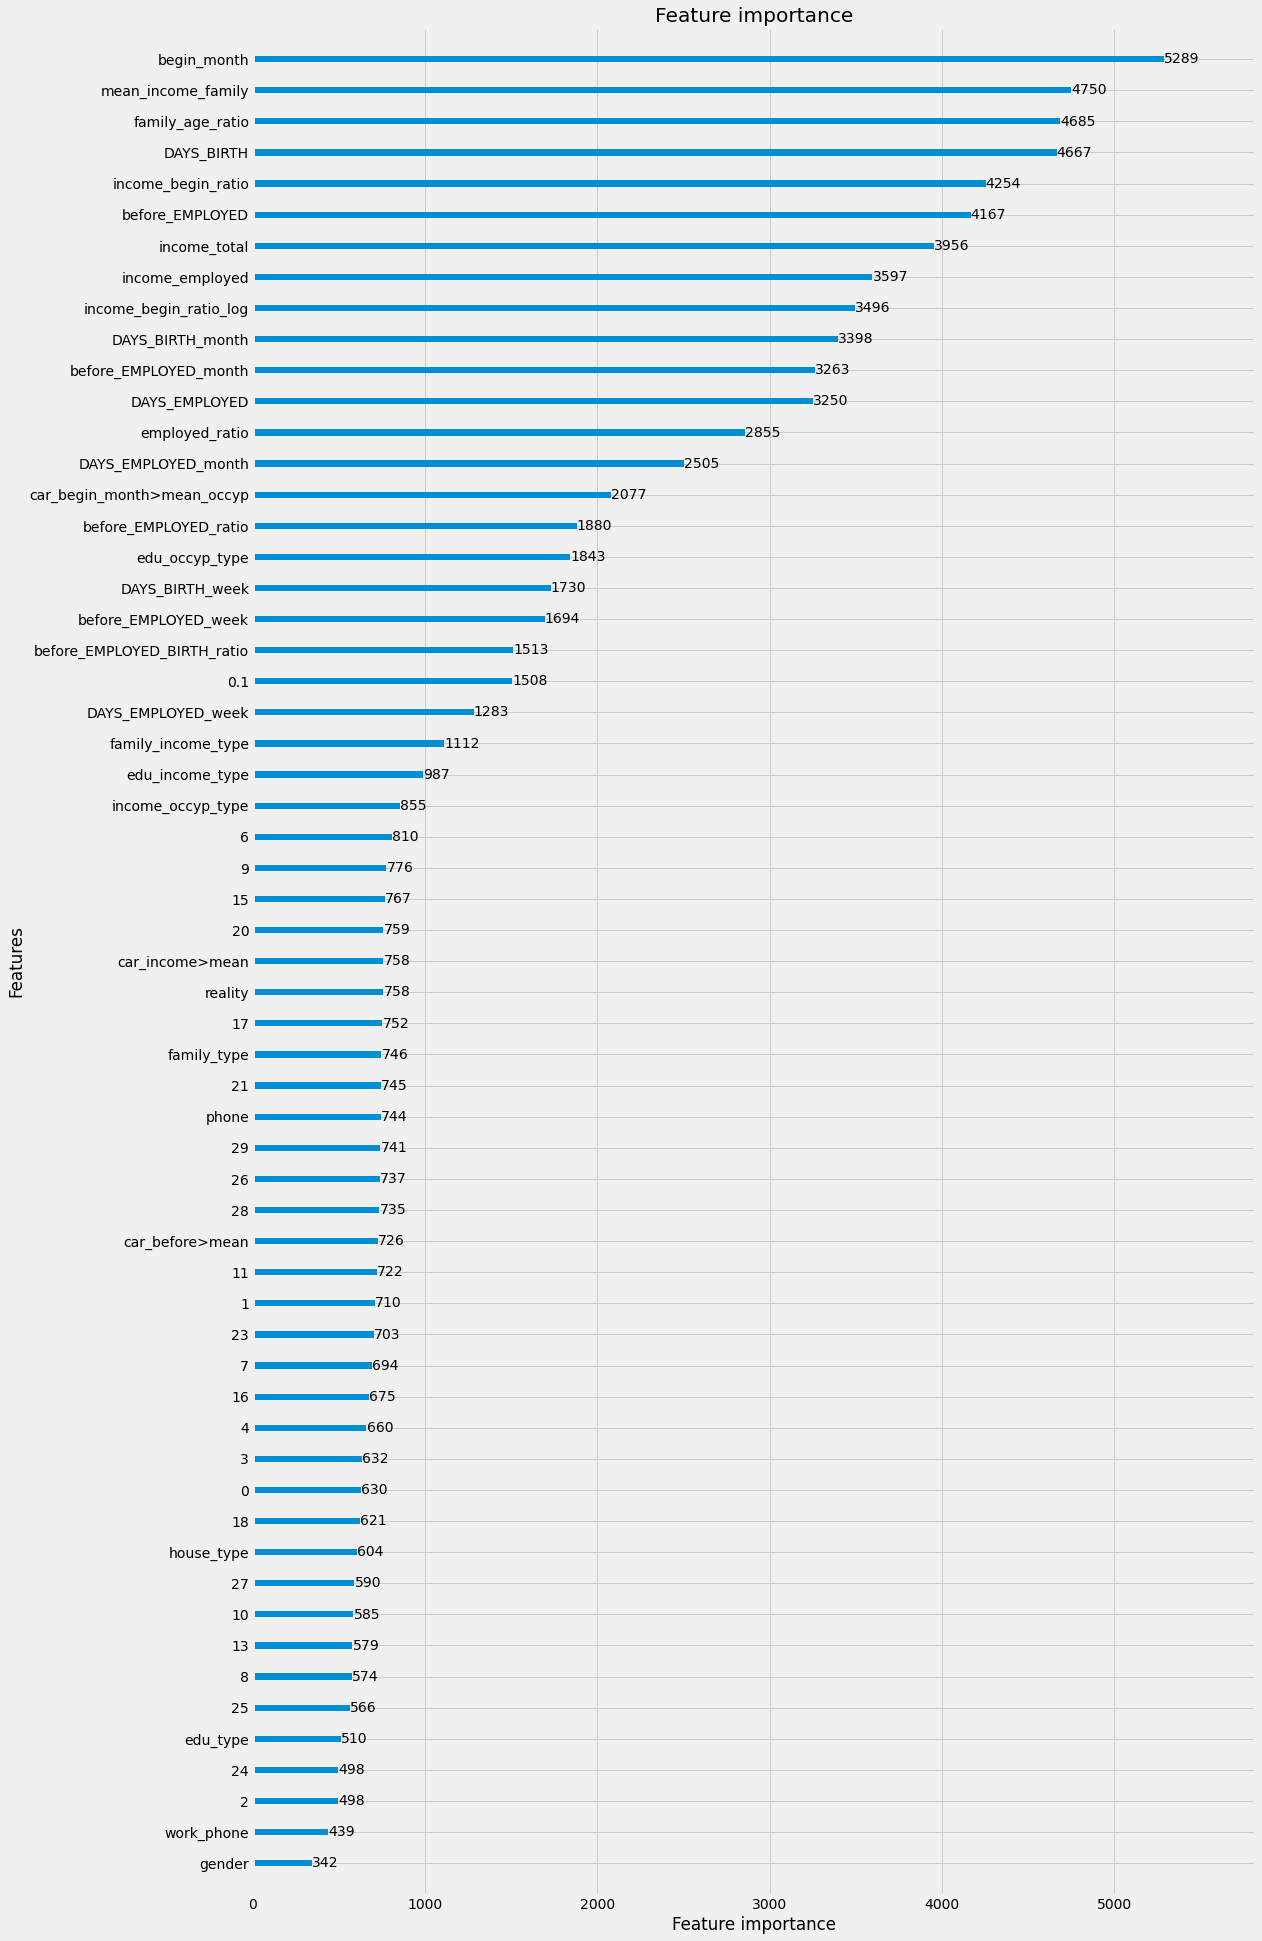

In [82]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)

#### Feature Selection & Cross Validation

In [196]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(clf, threshold='median')
smf.fit(ftr, target)
X_new = smf.transform(ftr)
X_te_new = smf.transform(X_tst)
feature_idx = smf.get_support()
feature_name = ftr.columns[feature_idx]

In [197]:
ftr.columns[feature_idx]

Index([                    'reality',                'income_total',
                       'family_type',                  'house_type',
                        'DAYS_BIRTH',               'DAYS_EMPLOYED',
                       'begin_month',                 'child_ratio',
                    'employed_ratio',  'EMPLOYED_begin_month_ratio',
                 'BIRTH_begin_ratio',          'mean_income_family',
                   'income_employed',          'income_begin_ratio',
                  'family_age_ratio',      'begin_month_DAYS_BIRTH',
         'begin_month_DAYS_EMPLOYED',                     'contact',
         'income_begin_family_ratio',            'DAYS_BIRTH_month',
                   'DAYS_BIRTH_week',         'DAYS_EMPLOYED_month',
                'DAYS_EMPLOYED_week',             'before_EMPLOYED',
             'before_EMPLOYED_month',        'before_EMPLOYED_week',
       'before_EMPLOYED_BIRTH_ratio',       'before_EMPLOYED_ratio',
       'before_EMPLOYED_begin_rati

In [198]:
X_new = pd.DataFrame(X_new)
X_te_new = pd.DataFrame(X_te_new)

X_new.columns = feature_name
X_te_new.columns = feature_name

In [199]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_new, target, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))
#7262

교차 검증별 정확도: [-0.7336 -0.7396 -0.7403 -0.742  -0.7291]
평균 검증 정확도: -0.7369


#### Bayesian Opt

In [100]:
ftr = X_new
target = y

In [101]:
from bayes_opt import BayesianOptimization

In [102]:
train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18555, 62), (7953, 62))

In [1206]:
bayesian_params = {
    'max_depth':(8, 16),
    'num_leaves':(24, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}

In [1207]:
def lgb_log_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators":2000, 
        "learning_rate":0.02,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='logloss', verbose=100, 
                early_stopping_rounds=100)
    valid_pred = lgb_model.predict_proba(valid_x)
    log_score = log_loss(valid_y, valid_pred)
    
    return log_score

In [1208]:
lgbBO = BayesianOptimization(f=lgb_log_eval, pbounds=bayesian_params, random_state=0)
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.79915	valid_1's multi_logloss: 0.808584
[200]	training's multi_logloss: 0.768326	valid_1's multi_logloss: 0.791777
[300]	training's multi_logloss: 0.746827	valid_1's multi_logloss: 0.783118
[400]	training's multi_logloss: 0.730788	valid_1's multi_logloss: 0.777345
[500]	training's multi_logloss: 0.719471	valid_1's multi_logloss: 0.77382
[600]	training's multi_logloss: 0.711311	valid_1's multi_logloss: 0.771587
[700]	training's multi_logloss: 0.707446	valid_1's multi_logloss: 0.770626
[800]	training's multi_logloss: 0.706626	valid_1's multi_logloss: 0.770529
[900]	training's multi_logloss: 0.706395	valid_1's multi_logloss: 0.7704

[100]	training's multi_logloss: 0.810249	valid_1's multi_logloss: 0.813713
[200]	training's multi_logloss: 0.790134	valid_1's multi_logloss: 0.800701
[300]	training's multi_logloss: 0.777725	valid_1's multi_logloss: 0.794497
[400]	training's multi_logloss: 0.770928	valid_1's multi_logloss: 0.79146
[500]	training's multi_logloss: 0.76784	valid_1's multi_logloss: 0.790245
[600]	training's multi_logloss: 0.766897	valid_1's multi_logloss: 0.789816
[700]	training's multi_logloss: 0.766374	valid_1's multi_logloss: 0.789591
[800]	training's multi_logloss: 0.766052	valid_1's multi_logloss: 0.789435
[900]	training's multi_logloss: 0.765978	valid_1's multi_logloss: 0.789391
[1000]	training's multi_logloss: 0.765956	valid_1's multi_logloss: 0.789379
[1100]	training's multi_logloss: 0.765948	valid_1's multi_logloss: 0.789374
[1200]	training's multi_logloss: 0.76594	valid_1's multi_logloss: 0.789371
[1300]	training's multi_logloss: 0.765937	valid_1's multi_logloss: 0.789369
[1400]	training's multi_

[2000]	training's multi_logloss: 0.789694	valid_1's multi_logloss: 0.798813
Did not meet early stopping. Best iteration is:
[2000]	training's multi_logloss: 0.789694	valid_1's multi_logloss: 0.798813
|  11       |  0.7988   |  0.927    |  246.8    |  12.74    |  115.7    |  4.465    |  28.89    |  47.41    |  9.401    |  0.8      |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.817865	valid_1's multi_logloss: 0.818153
[200]	training's multi_logloss: 0.80443	valid_1's multi_logloss: 0.807667
[300]	training's multi_logloss: 0.798752	valid_1's multi_logloss: 0.804029
[400]	training's multi_logloss: 0.796924	valid_1's multi_logloss: 0.802583
[500]	training's multi_logloss: 0.79621	valid_1's multi_logloss: 0.801948
[600]	training's multi_logloss: 0.795812	valid_1's multi_logloss: 0.801586
[700]	training's multi_logloss: 0.795606	valid_1's multi_logloss: 0.801401
[800]	training's multi_logloss: 0.795453	valid_1's multi_logloss: 0.80127
[900]	t

[200]	training's multi_logloss: 0.73232	valid_1's multi_logloss: 0.7816
[300]	training's multi_logloss: 0.702673	valid_1's multi_logloss: 0.770135
[400]	training's multi_logloss: 0.678355	valid_1's multi_logloss: 0.763748
[500]	training's multi_logloss: 0.659467	valid_1's multi_logloss: 0.759822
[600]	training's multi_logloss: 0.642141	valid_1's multi_logloss: 0.757035
[700]	training's multi_logloss: 0.626195	valid_1's multi_logloss: 0.75541
[800]	training's multi_logloss: 0.611973	valid_1's multi_logloss: 0.754395
[900]	training's multi_logloss: 0.599416	valid_1's multi_logloss: 0.752651
[1000]	training's multi_logloss: 0.586609	valid_1's multi_logloss: 0.750634
[1100]	training's multi_logloss: 0.574873	valid_1's multi_logloss: 0.750077
[1200]	training's multi_logloss: 0.562415	valid_1's multi_logloss: 0.749173
[1300]	training's multi_logloss: 0.553306	valid_1's multi_logloss: 0.748392
[1400]	training's multi_logloss: 0.544678	valid_1's multi_logloss: 0.748424
Early stopping, best ite

[1600]	training's multi_logloss: 0.790741	valid_1's multi_logloss: 0.799469
[1700]	training's multi_logloss: 0.790741	valid_1's multi_logloss: 0.799469
[1800]	training's multi_logloss: 0.790741	valid_1's multi_logloss: 0.799469
[1900]	training's multi_logloss: 0.790741	valid_1's multi_logloss: 0.799469
[2000]	training's multi_logloss: 0.790741	valid_1's multi_logloss: 0.799469
Did not meet early stopping. Best iteration is:
[2000]	training's multi_logloss: 0.790741	valid_1's multi_logloss: 0.799469
|  20       |  0.7995   |  1.0      |  500.0    |  8.0      |  10.0     |  1.0      |  64.0     |  50.0     |  0.001    |  1.0      |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.813341	valid_1's multi_logloss: 0.815552
[200]	training's multi_logloss: 0.797699	valid_1's multi_logloss: 0.804479
[300]	training's multi_logloss: 0.792157	valid_1's multi_logloss: 0.801072
[400]	training's multi_logloss: 0.790514	valid_1's multi_logloss: 0.799759


[1300]	training's multi_logloss: 0.611254	valid_1's multi_logloss: 0.752968
[1400]	training's multi_logloss: 0.602894	valid_1's multi_logloss: 0.752172
[1500]	training's multi_logloss: 0.595084	valid_1's multi_logloss: 0.751688
[1600]	training's multi_logloss: 0.58726	valid_1's multi_logloss: 0.75085
[1700]	training's multi_logloss: 0.579501	valid_1's multi_logloss: 0.750094
[1800]	training's multi_logloss: 0.572195	valid_1's multi_logloss: 0.749654
[1900]	training's multi_logloss: 0.56475	valid_1's multi_logloss: 0.749074
[2000]	training's multi_logloss: 0.557425	valid_1's multi_logloss: 0.748472
Did not meet early stopping. Best iteration is:
[2000]	training's multi_logloss: 0.557425	valid_1's multi_logloss: 0.748472
|  25       |  0.7485   |  0.5      |  500.0    |  8.0      |  10.0     |  50.0     |  24.0     |  0.01     |  8.542    |  0.5      |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.816767	valid_1's multi_logloss: 0.817806


|  29       |  0.7994   |  1.0      |  89.66    |  8.0      |  79.5     |  1.0      |  24.0     |  50.0     |  0.001    |  1.0      |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.817845	valid_1's multi_logloss: 0.818178
[200]	training's multi_logloss: 0.8044	valid_1's multi_logloss: 0.807628
[300]	training's multi_logloss: 0.798711	valid_1's multi_logloss: 0.803979
[400]	training's multi_logloss: 0.796849	valid_1's multi_logloss: 0.802514
[500]	training's multi_logloss: 0.796099	valid_1's multi_logloss: 0.801866
[600]	training's multi_logloss: 0.795667	valid_1's multi_logloss: 0.801494
[700]	training's multi_logloss: 0.79547	valid_1's multi_logloss: 0.801311
[800]	training's multi_logloss: 0.795355	valid_1's multi_logloss: 0.801203
[900]	training's multi_logloss: 0.795259	valid_1's multi_logloss: 0.801117
[1000]	training's multi_logloss: 0.795185	valid_1's multi_logloss: 0.801058
[1100]	training's multi_logloss: 0.795163	valid_1's mult

In [1209]:
lgbBO.res

[{'target': 0.7704609088897594,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.822107008573152,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 0.7421905608435697,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 12.231159358023236,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 0.7387224494481152,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.828946737862111,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.6124

In [1210]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('minimum target index:', np.argmin(np.array(target_list)))

[0.7704609088897594, 0.7421905608435697, 0.7387224494481152, 0.7828276251088339, 0.7914861137780663, 0.8001313599091029, 0.7893642602823298, 0.7443782901691818, 0.7381410490182178, 0.8010262896334476, 0.7988134885147147, 0.8010687178690195, 0.7988422327605844, 0.7995129756271849, 0.7995891284310326, 0.7481517274817083, 0.8009648154908557, 0.8012598654175598, 0.7995676717952767, 0.799468829478731, 0.7987704989464589, 0.7852469351029481, 0.800751693730512, 0.7780395809780917, 0.7484722745896683, 0.8008478424568978, 0.8008478424568978, 0.8011981411160523, 0.7994303579288522, 0.8010015910934065]
minimum target index: 8


In [1211]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
min_dict = lgbBO.res[np.argmin(np.array(target_list))]
print(min_dict)

{'target': 0.7381410490182178, 'params': {'colsample_bytree': 1.0, 'max_bin': 264.5320531371466, 'max_depth': 16.0, 'min_child_samples': 200.0, 'min_child_weight': 1.0, 'num_leaves': 64.0, 'reg_alpha': 0.01, 'reg_lambda': 10.0, 'subsample': 0.5}}


In [1212]:
ftr = X
target = y

In [349]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros(ftr.shape[0])
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros((X_tst.shape[0], 3))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMClassifier(
                n_jobs=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth=16,
                num_leaves=55,
                colsample_bytree=0.889,
                subsample=0.571,
                max_bin=436,
                reg_alpha=5.92,
                reg_lambda=6.39,
                min_child_weight=23.6,
                min_child_samples=162,
                silent=-1,
                verbose=-1,
                )
    
    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration', fold_idx, '시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx, :]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx, :]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 200, 
                early_stopping_rounds= 200)
        
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]    
        
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산.
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict_proba(X_tst, num_iteration=clf.best_iteration_)/folds.n_splits
             
    return clf, test_preds

In [350]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration 0 시작
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.761844	valid_1's multi_logloss: 0.79372
[400]	training's multi_logloss: 0.709567	valid_1's multi_logloss: 0.770803
[600]	training's multi_logloss: 0.671042	valid_1's multi_logloss: 0.757177
[800]	training's multi_logloss: 0.640496	valid_1's multi_logloss: 0.748212
[1000]	training's multi_logloss: 0.615079	valid_1's multi_logloss: 0.742874
[1200]	training's multi_logloss: 0.593437	valid_1's multi_logloss: 0.739359
[1400]	training's multi_logloss: 0.574343	valid_1's multi_logloss: 0.737475
[1600]	training's multi_logloss: 0.557174	valid_1's multi_logloss: 0.735254
[1800]	training's multi_logloss: 0.541688	valid_1's multi_logloss: 0.733553
[2000]	training's multi_logloss: 0.527711	valid_1's multi_logloss: 0.732845
[2200]	training's multi_logloss: 0.515105	valid_1's multi_logloss: 0.732401
[2400]	training's multi_logloss: 0.503389	valid_1's multi_logloss: 0.732325
Early stop

In [351]:
sub[sub.columns] = test_preds
sub.head()

,0,1,2
index,,,
26457,0.044776,0.149291,0.805933
26458,0.177609,0.201100,0.621291
26459,0.041875,0.074039,0.884087
26460,0.092851,0.129887,0.777262
26461,0.089852,0.181484,0.728664


In [353]:
sub.to_csv('0516(feature+w2v).csv')

### catboost

In [192]:
X = X_new
X_tst = X_te_new
y = trn['credit']

In [193]:
ftr = X
target = y

In [194]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18519, 64), (7938, 64))

In [195]:
from catboost import CatBoostClassifier

In [196]:
clf = CatBoostClassifier(
    iterations=2000, 
    learning_rate=0.01, 
    loss_function='multilogloss'
)

In [197]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros((ftr.shape[0], 3))
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros((X_tst.shape[0], 3))
    
    # n_estimators를 4000까지 확대. 
    clf = CatBoostClassifier(random_state=0, iterations=4000, eval_metric='MultiClass')

    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration', fold_idx, '시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx, :]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx, :]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], verbose= 200, 
                early_stopping_rounds= 200)
        
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        oof_preds[valid_idx] = clf.predict_proba(valid_x)   
        
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산.
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict_proba(X_tst)/folds.n_splits
             
    return clf, test_preds

In [198]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration 0 시작
Learning rate set to 0.067585
0:	learn: 1.0603687	test: 1.0603687	test1: 1.0605449	best: 1.0605449 (0)	total: 20.9ms	remaining: 1m 23s
200:	learn: 0.7468522	test: 0.7468522	test1: 0.7836805	best: 0.7836805 (200)	total: 4.06s	remaining: 1m 16s
400:	learn: 0.6941652	test: 0.6941652	test1: 0.7636034	best: 0.7635863 (399)	total: 8.28s	remaining: 1m 14s
600:	learn: 0.6527794	test: 0.6527794	test1: 0.7523386	best: 0.7523386 (600)	total: 12.7s	remaining: 1m 11s
800:	learn: 0.6169346	test: 0.6169346	test1: 0.7449556	best: 0.7449556 (800)	total: 17s	remaining: 1m 7s
1000:	learn: 0.5852927	test: 0.5852927	test1: 0.7399597	best: 0.7399036 (998)	total: 21.2s	remaining: 1m 3s
1200:	learn: 0.5583048	test: 0.5583048	test1: 0.7369265	best: 0.7368898 (1192)	total: 25.4s	remaining: 59.3s
1400:	learn: 0.5340276	test: 0.5340276	test1: 0.7348152	best: 0.7347225 (1396)	total: 29.6s	remaining: 54.9s
1600:	learn: 0.5129646	test: 0.5129646	test1: 0.7333805	best: 0.7333732 (1599)	total: 33.

KeyboardInterrupt: 

In [ ]:
test_preds.shape

In [ ]:
sub[sub.columns] = test_preds
sub.head()

In [28]:
sub.to_csv('0517(all)_cat.csv')